In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

### Read un-normalized input matrices

In [3]:
from vpolo.alevin import parser #pip install vpolo

matrix_1_path = "../alevin-test-plot/full/"
matrix_2_path = "../alevin-test-plot/half"

matrix_1 = parser.read_quants_bin(matrix_1_path)

matrix_2 = parser.read_quants_bin(matrix_2_path)

../alevin-test-plot/full/alevin
 Done reading 900 cells
Read total 931 cells
Found total 10986217.999994637 reads
../alevin-test-plot/half/alevin
 Done reading 900 cells
Read total 931 cells
Found total 8007958.999993067 reads


In [4]:
matrix_1.shape, matrix_2.shape

((931, 52325), (931, 52325))

In [7]:
sample_length = min(min(len(matrix_1.index), len(matrix_2.index)), 1000)

# use .sample
matrix_1_sampled = matrix_1.sample(sample_length)
matrix_2_sampled = matrix_2.sample(sample_length)

CPU times: user 2min 33s, sys: 1min 1s, total: 3min 35s
Wall time: 36.2 s


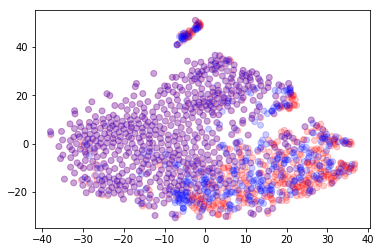

In [8]:
# Awesome library for super fast tSNE projection
from MulticoreTSNE import MulticoreTSNE as TSNE

ct = np.concatenate([matrix_1_sampled.values, matrix_2_sampled.values], axis=0)
tsne = TSNE(n_jobs=8)
%time Y = tsne.fit_transform(ct)

plt.scatter(Y[:,0], Y[:,1], c = ['r'] * matrix_1_sampled.shape[0] + ['b'] * matrix_2_sampled.shape[0], alpha=0.2)

### Calculate reads per cell

In [9]:
# There seems to be bias on the lower right end of the tSNE plot
# The algorithm for Depth normalization is inspired from here
# https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/aggregate#depth_normalization

# Calculate the reads per cell ration across the sample
rpc_1 = matrix_1.sum().sum() / len(matrix_1.index)
rpc_2 = matrix_2.sum().sum() / len(matrix_2.index)

In [10]:
rpc_1, rpc_2

(11800.448979586068, 8601.459720722947)

In [11]:
# Calculating the fractions of reads to keep
frac_kept_reads = min(rpc_1, rpc_2) / max(rpc_1, rpc_2)
frac_kept_reads

0.7289095301037153

### Divide cell values of matrix with greater rpc by fraction

In [13]:
if rpc_1 < rpc_2:
    matrix_s = matrix_1
else:
    matrix_s = matrix_2
matrix_norm = matrix_s / frac_kept_reads

In [14]:
matrix_norm_sampled = matrix_norm.sample(sample_length)

CPU times: user 2min 36s, sys: 56.5 s, total: 3min 33s
Wall time: 37.2 s


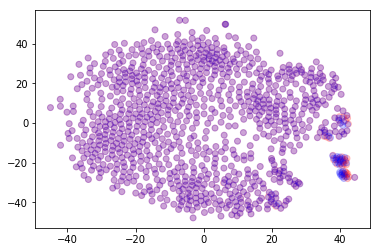

In [15]:
# Awesome library for super fast tSNE projection
from MulticoreTSNE import MulticoreTSNE as TSNE

ct = np.concatenate([matrix_norm_sampled.values, matrix_1_sampled.values], axis=0)
tsne = TSNE(n_jobs=8)
%time Y = tsne.fit_transform(ct)

plt.scatter(Y[:,0], Y[:,1], c = ['r'] * matrix_norm_sampled.shape[0] + ['b'] * matrix_1_sampled.shape[0], alpha=0.2)

### Plot matrices normalized from C++ code

In [16]:
from vpolo.alevin import parser #pip install vpolo

matrix_3_path = "../alevin-test-op-plot/full"
matrix_4_path = "../alevin-test-op-plot/half"

matrix_3 = parser.read_quants_bin(matrix_3_path)

matrix_4 = parser.read_quants_bin(matrix_4_path)

../alevin-test-op-plot/full/alevin
 Done reading 900 cells
Read total 931 cells
Found total 10986217.999994637 reads
../alevin-test-op-plot/half/alevin
 Done reading 900 cells
Read total 931 cells
Found total 10986387.187526764 reads


In [17]:
matrix_3.shape, matrix_4.shape

((931, 52325), (931, 52325))

In [18]:
matrix_3_sampled = matrix_3.sample(sample_length)
matrix_4_sampled = matrix_4.sample(sample_length)

CPU times: user 2min 32s, sys: 52.8 s, total: 3min 25s
Wall time: 35.8 s


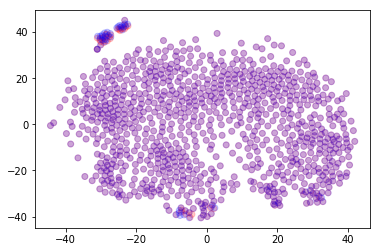

In [19]:
# Awesome library for super fast tSNE projection
from MulticoreTSNE import MulticoreTSNE as TSNE

ct = np.concatenate([matrix_3_sampled.values, matrix_4_sampled.values], axis=0)
tsne = TSNE(n_jobs=8)
%time Y = tsne.fit_transform(ct)

plt.scatter(Y[:,0], Y[:,1], c = ['r'] * matrix_3_sampled.shape[0] + ['b'] * matrix_4_sampled.shape[0], alpha=0.2)

### Use method from https://gist.github.com/k3yavi/55be0c0c660f1c0034f2d11df31bec00 to normalize

In [20]:
if rpc_1 > rpc_2:
    matrix_l = matrix_1
else:
    matrix_l = matrix_2
    
matrix_norm = []
for row in matrix_l.values:
    new_row = np.random.binomial(list(map(int, np.around(row))), frac_kept_reads)
    matrix_norm.append(new_row)

print(len(matrix_norm), len(matrix_norm[0]))

931 52325


CPU times: user 2min 29s, sys: 55 s, total: 3min 24s
Wall time: 36.8 s


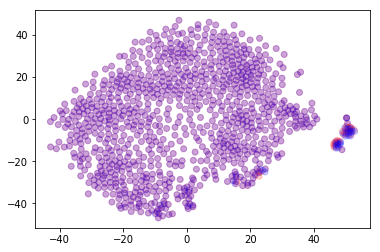

In [21]:
# Awesome library for super fast tSNE projection
from MulticoreTSNE import MulticoreTSNE as TSNE

# plotting again the subsampled full data and the original half data
ct1 = np.concatenate([matrix_norm, matrix_2.values], axis=0)
tsne1 = TSNE(n_jobs=8)
%time Y = tsne1.fit_transform(ct1)

plt.scatter(Y[:,0], Y[:,1], c = ['r'] * len(matrix_norm) + ['b'] * matrix_s.shape[0], alpha=0.2)